## AT&T Spam Detector
Building a model to detect spams in text messages

#### Importing libraries

In [ ]:
pip install tensorflow

In [ ]:
pip install keras

In [ ]:
pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 11.3 MB/s eta 0:00:00


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras import Sequential
import tensorflow_hub as hub
import tensorflow_text

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

#### I. Exploring the data

In [25]:
pd.read_csv("/content/cleaned_spam_data.csv")

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [26]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


The data is categorized "ham" (legitimate message) or "spam".

In [27]:
# concatenating all text into one column and dropping the rest
df['v2'] = df[df.columns[1:]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
df = df.astype('string')
df = df.drop(['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'],axis=1)

display(df.describe())
display(df.head())

,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


We can notice the spelling particularities of this type of messaging. It is difficult to predict how this will affect our model, but presumably won't help.

<ipython-input-31-717ed6510873>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='v1', palette=colors)


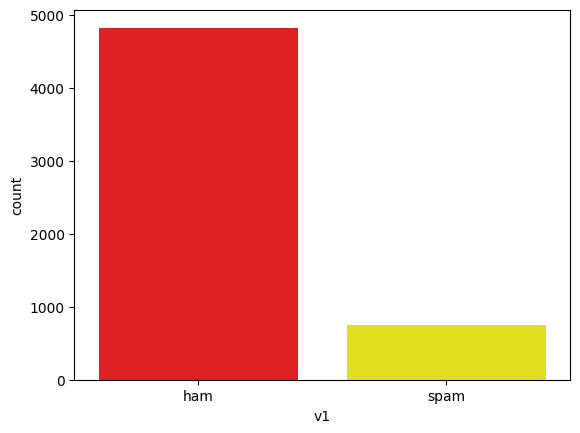

In [31]:

colors = ["#ff0000", "#ffff00"]

sns.countplot(data=df, x='v1', palette=colors)

# Show the plot
plt.show()

In [32]:
print(f"{round(df.v1.value_counts()[1]/len(df.v1)*100,2)}% of spams in data")

13.41% of spams in data


The data is imbalanced, but should still be a sufficient sample to get interesting results.

#### II. Preprocessing

In [33]:
df['target'] = df.v1.map({'ham':0,'spam':1}) # labeling our target into 0s and 1s

df['clean_text'] = df['v2'].str.replace(r"[\W_]+", " ",regex=True)
df['clean_text'] = df['clean_text'].fillna('').apply(lambda x: x.lower())

df.head()

,v1,v2,target,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,0,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah i don t think he goes to usf he lives arou...


In [34]:
# splitting usual "X_train/val/test" in 2 X sets : "Encoded_p" with encoded padding for logistic regression and simple embedding model, "Raw" text for BERT later
# in this particular instance, doing this & multiplying variables won't be a memory issue since the dataset is so small

Raw_train, Raw_test, y_train, y_test = train_test_split(df.clean_text, df.target, test_size=0.1, random_state=1,stratify=df.target)

Raw_train, Raw_val, y_train, y_val = train_test_split(Raw_train, y_train, test_size=0.1, random_state=1,stratify=y_train)

In [35]:
# encoding our text
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(Raw_train)
Encoded_train = tokenizer.texts_to_sequences(Raw_train)
Encoded_test = tokenizer.texts_to_sequences(Raw_test)
Encoded_val = tokenizer.texts_to_sequences(Raw_val)

# padding with a maxlen so all our sequences have the same length
Encoded_p_train = tf.keras.preprocessing.sequence.pad_sequences(Encoded_train, maxlen=190, padding="post")
Encoded_p_test = tf.keras.preprocessing.sequence.pad_sequences(Encoded_test, maxlen=190, padding="post")
Encoded_p_val = tf.keras.preprocessing.sequence.pad_sequences(Encoded_val, maxlen=190, padding="post")

In [36]:
vocab_size = len(tokenizer.word_counts)
max_len = max([len(sent) for sent in Encoded_train])
print(f" The vocabulary has {vocab_size} tokens and the longest message has {max_len}")

 The vocabulary has 7886 tokens and the longest message has 190


In [37]:
Encoded_p_train[0][:15]
# padding added 0s so our sequences all have the same size

array([  20,    4, 1126,  130,   84,    6,   42,  343,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [38]:
# creating tf datasets from our splits, shuffling and making batches
Enc_train_ds = tf.data.Dataset.from_tensor_slices((Encoded_p_train, y_train))
Enc_test_ds = tf.data.Dataset.from_tensor_slices((Encoded_p_test, y_test))
Enc_val_ds = tf.data.Dataset.from_tensor_slices((Encoded_p_val, y_val))

Raw_train_ds = tf.data.Dataset.from_tensor_slices((Raw_train, y_train))
Raw_test_ds = tf.data.Dataset.from_tensor_slices((Raw_test, y_test))
Raw_val_ds = tf.data.Dataset.from_tensor_slices((Raw_val, y_val))

Enc_train_ds = Enc_train_ds.shuffle(len(Enc_train_ds)).batch(64)
Enc_test_ds = Enc_test_ds.shuffle(len(Enc_test_ds)).batch(64)
Enc_val_ds = Enc_val_ds.shuffle(len(Enc_val_ds)).batch(64)

Raw_train_ds = Raw_train_ds.shuffle(len(Raw_train_ds)).batch(64)
Raw_test_ds = Raw_test_ds.shuffle(len(Raw_test_ds)).batch(64)
Raw_val_ds = Raw_val_ds.shuffle(len(Raw_val_ds)).batch(64)

#### III. Establishing a baseline

In [42]:
lr = LogisticRegression(max_iter=1500)
lr.fit(Encoded_p_train,y_train)
pred_logreg = lr.predict(Encoded_p_test)

print(classification_report(y_test,pred_logreg))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       483
           1       0.65      0.20      0.31        75

    accuracy                           0.88       558
   macro avg       0.77      0.59      0.62       558
weighted avg       0.86      0.88      0.85       558



In [43]:
nb = MultinomialNB()
nb.fit(Encoded_p_train,y_train)
nb_pred = nb.predict(Encoded_p_test)

print(classification_report(y_test,nb_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       483
           1       0.45      0.64      0.53        75

    accuracy                           0.85       558
   macro avg       0.70      0.76      0.72       558
weighted avg       0.87      0.85      0.86       558



A simple logistic regression stops a few spams, but it's not very satisfying. Multinomial Naive Bayes catches more, but also misidentifies more hams.<br>
Both are not very useful in production but will provide a decent reference.

#### IV. A simple embedding

In [44]:
embedding_dim=128

model_1 = Sequential([
  Embedding(vocab_size+1, embedding_dim),
  GlobalAveragePooling1D(),
  Dense(64, activation='relu'),
  Dense(32, activation='relu'),
  Dense(1, activation="sigmoid")
])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         1009536   
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1019905 (3.89 MB)
Trainable params: 1019905 (3.89 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [45]:
# the adamax variant on the optimizer reportedly can achieve better performance in model with embeddings, but it wasn't the case with ours
# we may have too little data to tweak our model to this level
model_1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),metrics=tf.keras.metrics.BinaryAccuracy())
hist = model_1.fit(Enc_train_ds,validation_data=Enc_val_ds,epochs=15)

Epoch 1/15
71/71 [==============================] - 2s 19ms/step - loss: 0.4496 - binary_accuracy: 0.8659 - val_loss: 0.3710 - val_binary_accuracy: 0.8665
Epoch 2/15
71/71 [==============================] - 1s 16ms/step - loss: 0.3538 - binary_accuracy: 0.8659 - val_loss: 0.3329 - val_binary_accuracy: 0.8665
Epoch 3/15
71/71 [==============================] - 1s 15ms/step - loss: 0.2490 - binary_accuracy: 0.8770 - val_loss: 0.1756 - val_binary_accuracy: 0.9442
Epoch 4/15
71/71 [==============================] - 1s 21ms/step - loss: 0.0980 - binary_accuracy: 0.9747 - val_loss: 0.0973 - val_binary_accuracy: 0.9661
Epoch 5/15
71/71 [==============================] - 1s 16ms/step - loss: 0.0375 - binary_accuracy: 0.9894 - val_loss: 0.0680 - val_binary_accuracy: 0.9801
Epoch 6/15
71/71 [==============================] - 1s 16ms/step - loss: 0.0226 - binary_accuracy: 0.9934 - val_loss: 0.0591 - val_binary_accuracy: 0.9861
Epoch 7/15
71/71 [==============================] - 1s 16ms/step - los

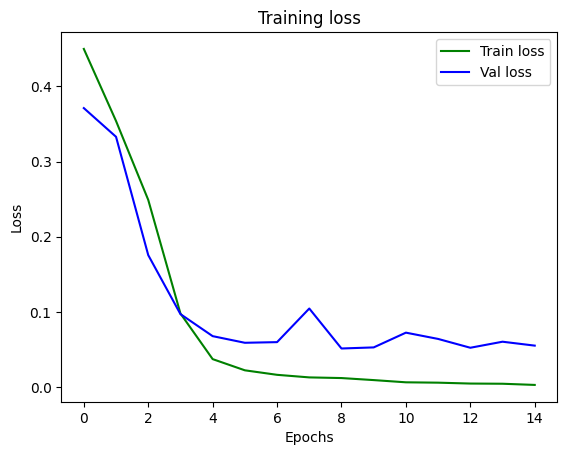

In [46]:
plt.plot(hist.epoch, hist.history["loss"], 'g', label='Train loss')
plt.plot(hist.epoch, hist.history["val_loss"], 'b', label='Val loss')
plt.gca().set(title='Training loss',xlabel='Epochs',ylabel='Loss')
plt.legend()
plt.show()

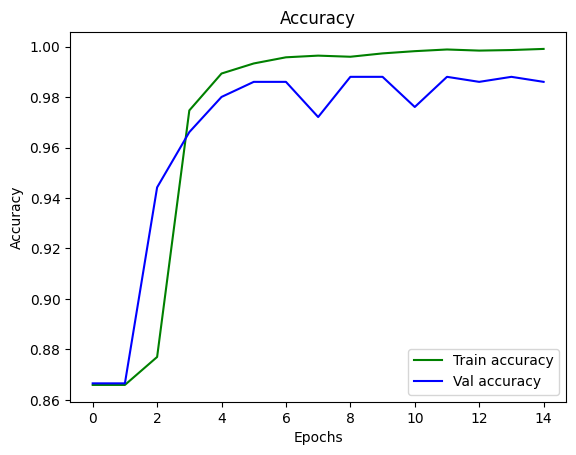

In [47]:
plt.plot(hist.epoch, hist.history["binary_accuracy"], 'g', label='Train accuracy')
plt.plot(hist.epoch, hist.history["val_binary_accuracy"], 'b', label='Val accuracy')
plt.gca().set(title='Accuracy',xlabel='Epochs',ylabel='Accuracy')
plt.legend()
plt.show()

The model trains really fast and more epochs don't improve performance ; it's already very high !

In [49]:
# Save & restore model
model_1.save('./data/model_1.h5')
model_1 = tf.keras.models.load_model('./data/model_1.h5')

loss, acc = model_1.evaluate(Enc_test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 - 0s - loss: 0.0178 - binary_accuracy: 0.9946 - 469ms/epoch - 52ms/step
Restored model, accuracy: 99.46%


In [50]:
predictions = model_1.predict(Encoded_p_test)
predictions = predictions.reshape(-1)
results_1 = pd.DataFrame({'test':y_test,'pred':predictions})
results_1['pred'] = round(results_1['pred'])
print(classification_report(results_1.test,results_1.pred))

18/18 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       483
           1       1.00      0.96      0.98        75

    accuracy                           0.99       558
   macro avg       1.00      0.98      0.99       558
weighted avg       0.99      0.99      0.99       558



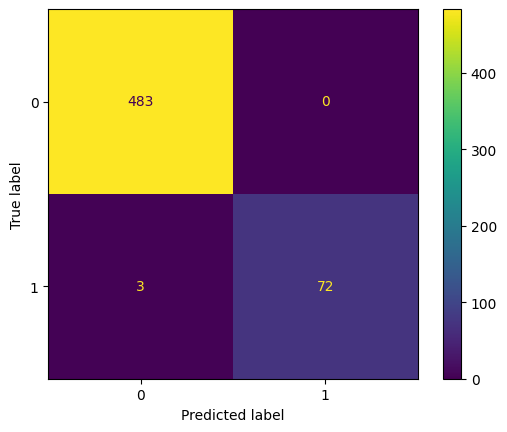

In [51]:
cm_test = confusion_matrix(results_1.test,results_1.pred)
ConfusionMatrixDisplay(cm_test).plot()
plt.show()

This means that on our test sample, the model failed only 6 times to identify a spam (out of 75) and never flagged a ham as spam (out of 483 instances).<br>
The performance is excellent and a clear improvement upon logistic regression : 92% of spams are blocked and zero legitimate messages are wrongly categorized as spams.

#### V. Importing a pre-trained model
##### A) A small model pre-trained on text

A look into BERT models' preprocessing

In [52]:
text_test = [df.clean_text[3]]
bert_preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
text_preprocessed = bert_preprocessor(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :20]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :20]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :20]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  1057 24654  2360  2061  2220  7570  2099  1057  1039  2525  2059
  2360   102     0     0     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [53]:
def build_model_2():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = bert_preprocessor
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer('https://tfhub.dev/google/electra_small/2', trainable=False, name='Electra')
  outputs = encoder(encoder_inputs)
  out = outputs['pooled_output']
  new = tf.keras.layers.Dense(64, activation='relu')(out)
  new = tf.keras.layers.Dropout(0.1)(new)
  clf = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(new)
  return tf.keras.Model(text_input, clf)

# paper on ELECTRA : https://arxiv.org/abs/2003.10555

In [54]:
model_2 = build_model_2()
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [56]:
model_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),metrics=tf.keras.metrics.BinaryAccuracy())
hist = model_2.fit(x=Raw_train_ds,validation_data=Raw_val_ds,epochs=5)

Epoch 1/5
71/71 [==============================] - 407s 6s/step - loss: 0.0664 - binary_accuracy: 0.9787 - val_loss: 0.0508 - val_binary_accuracy: 0.9880
Epoch 2/5
71/71 [==============================] - 403s 6s/step - loss: 0.0636 - binary_accuracy: 0.9809 - val_loss: 0.0481 - val_binary_accuracy: 0.9880
Epoch 3/5
71/71 [==============================] - 364s 5s/step - loss: 0.0622 - binary_accuracy: 0.9783 - val_loss: 0.0469 - val_binary_accuracy: 0.9880
Epoch 4/5
71/71 [==============================] - 368s 5s/step - loss: 0.0586 - binary_accuracy: 0.9805 - val_loss: 0.0466 - val_binary_accuracy: 0.9880
Epoch 5/5
71/71 [==============================] - 357s 5s/step - loss: 0.0542 - binary_accuracy: 0.9840 - val_loss: 0.0463 - val_binary_accuracy: 0.9900


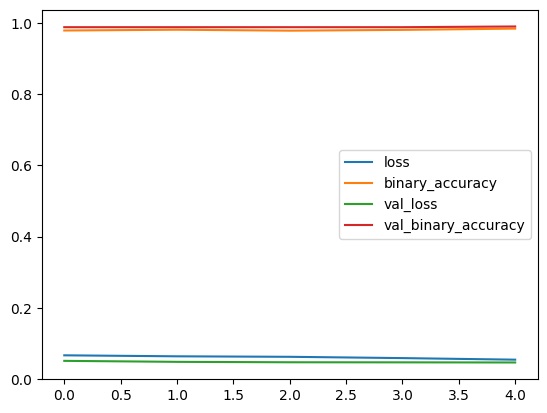

In [58]:
pd.DataFrame(hist.history).plot()
plt.show()

In [59]:
model_2.save('./data/model_2.h5')
model_2 = tf.keras.models.load_model('./data/model_2.h5',custom_objects={'KerasLayer':hub.KerasLayer})

loss, acc = model_2.evaluate(Raw_test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 - 40s - loss: 0.0716 - binary_accuracy: 0.9767 - 40s/epoch - 4s/step
Restored model, accuracy: 97.67%


In [60]:
predictions = model_2.predict(Raw_test)
predictions = predictions.reshape(-1)
results_2 = pd.DataFrame({'test':y_test,'pred':predictions})
results_2['pred'] = round(results_2['pred'])
print(classification_report(results_2.test,results_2.pred))

18/18 [==============================] - 37s 2s/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       483
           1       0.96      0.87      0.91        75

    accuracy                           0.98       558
   macro avg       0.97      0.93      0.95       558
weighted avg       0.98      0.98      0.98       558



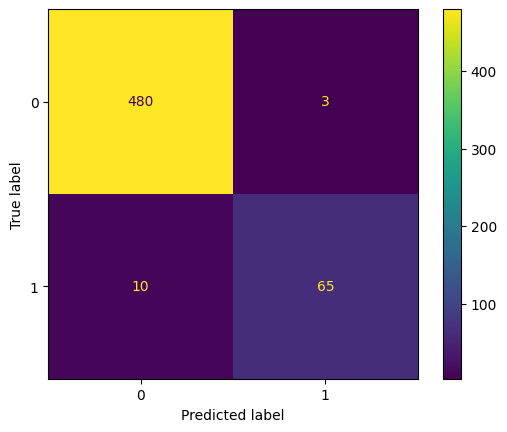

In [61]:
cm_test = confusion_matrix(results_2.test,results_2.pred)
ConfusionMatrixDisplay(cm_test).plot()
plt.show()

The imported model gives decent results immediately after 1 epoch (naturally since it's already trained on other text data), but while it does a lot better than classification with logistic regression and multinomial naive bayes, it fails to improve upon our previous model (a tall order, admittedly).<br>
The model is still improving so we could keep training and probably see some improvement or re-train the model entirely, but maybe our time would be better spent finding something already more suited to our task !

##### B) A larger model pre-trained on this specific task

In [62]:
tokenizer = AutoTokenizer.from_pretrained("mariagrandury/roberta-base-finetuned-sms-spam-detection")
model = TFAutoModelForSequenceClassification.from_pretrained("mariagrandury/roberta-base-finetuned-sms-spam-detection",from_pt=True)

# Reference : https://huggingface.co/mariagrandury/roberta-base-finetuned-sms-spam-detection

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [63]:
inputs = tokenizer(list(Raw_test), return_tensors="tf",padding=True)
outputs = model(inputs)
roberta_res = [np.argmax(x) for x in outputs[0]]

In [64]:
results_3 = pd.DataFrame({'test':y_test,'pred':roberta_res})
print(classification_report(results_3.test,results_3.pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       483
           1       1.00      0.95      0.97        75

    accuracy                           0.99       558
   macro avg       1.00      0.97      0.98       558
weighted avg       0.99      0.99      0.99       558



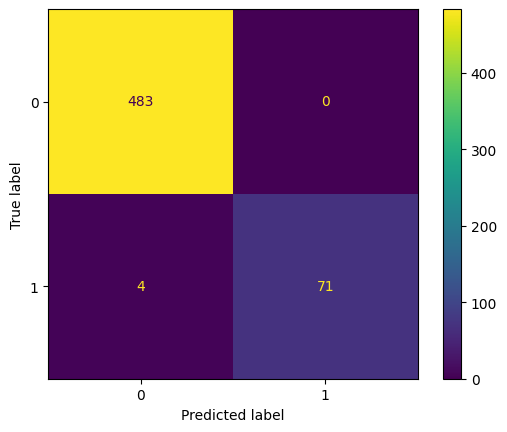

In [65]:
cm_test = confusion_matrix(results_3.test,results_3.pred)
ConfusionMatrixDisplay(cm_test).plot()
plt.show()

#### VI. Conclusion

In [66]:
baseline_model_results = classification_report(y_test,pred_logreg, output_dict=True)
model_nb_results = classification_report(y_test,nb_pred, output_dict=True)
model_1_results = classification_report(results_1.test,results_1.pred, output_dict=True)
model_2_results = classification_report(results_2.test,results_2.pred, output_dict=True)
model_3_results = classification_report(results_3.test,results_3.pred, output_dict=True)

total_results = pd.DataFrame({'Logistic Regression':baseline_model_results['1'],
                            'Multinomial Naive Bayes':model_nb_results['1'],
                             'Custom Embedding Model':model_1_results['1'],
                             'BERT-ELECTRA Model':model_2_results['1'],
                             'RoBERTa spam detection':model_3_results['1']}).transpose()

total_results.iloc[:,:3]

,precision,recall,f1-score
Logistic Regression,0.652174,0.200000,0.306122
Multinomial Naive Bayes,0.452830,0.640000,0.530387
Custom Embedding Model,1.000000,0.960000,0.979592
BERT-ELECTRA Model,0.955882,0.866667,0.909091
RoBERTa spam detection,1.000000,0.946667,0.972603


The pre-trained RoBERTa was best ; a more sophisticated model with more training, it is the best solution to filter spams.<br>
Implementing the model from the transformers library was exceedingly easy and efficient ; it is very useful to check if maybe someone has already done all the work for the task at hand !<br>
The results are very promising and immediately useful, with only 5% of spams getting through.<br><br>

Our custom (and very light) embedding model performed really well though, even if it is difficult to be absolutely sure that it would be able to generalize on a much larger amount of messages (and therefore variety of content) with the small amount of data at our disposal.<br>
It shows that a bigger and more complicated structure is not always the solution. If the size of the model is an important parameter, our custom model would be ideal.

<br>
To improve further, we could combine our results with a list of phone numbers already identified as spam-senders to eliminate the few remaining spams, and/or try to identify other behavioral patterns not contained in the text (how many identical messages were sent, at what frequency...).